### Imports

In [85]:
# Libraries
import os
from importlib import reload

import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scripts
from acml import data, runners, utils

In [86]:
!pip show tensorflow

Name: tensorflow
Version: 2.10.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [87]:
!pip show keras

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: c:\users\sonar\anaconda3v2\envs\acml_2024\lib\site-packages
Requires: 
Required-by: keras-tuner, tensorflow


In [88]:
reload(runners)
reload(data)
reload(utils)

<module 'acml.utils' from 'c:\\Users\\sonar\\Desktop\\acml_2024_s2\\runner\\acml\\utils.py'>

In [89]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

# Check whether tf is using the GPU
utils.check_gpu_use() 


GPU DETECTED ✓
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## `main`

In [90]:
INPUT_SIZE=(128, 128)
BATCH_SIZE = 4

### Load data

In [91]:
pairs_df = pd.read_csv("data/deepship_pairs_2.csv")
pairs_df.head()

,ship_name,file_path_1,date_seg_1,file_path_2,date_seg_2
0,ALFRED_N,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170326_1,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170403_54
1,ALFRED_N,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170326_2,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170403_39
2,ALFRED_N,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170326_3,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170403_36
3,ALFRED_N,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170326_4,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170403_11
4,ALFRED_N,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170326_5,data\deepship_ps_2_npz\Tanker\ALFRED_N-80-2017...,20170403_45


In [92]:
NPZ = True

if NPZ:
    pairs_df.loc[:, "input_spec"] = pairs_df["file_path_1"].apply(
        lambda x: np.load(x)['np_data']
    )
    pairs_df.loc[:, "label_spec"] = pairs_df["file_path_2"].apply(
        lambda x: np.load(x)['np_data']
    )
else:
    pairs_df.loc[:, "input_spec"] = pairs_df["file_path_1"].apply(
        lambda x: pd.read_csv(x, header=None).values
    )
    pairs_df.loc[:, "label_spec"] = pairs_df["file_path_2"].apply(
        lambda x: pd.read_csv(x, header=None).values
    )

X_train_1d = pairs_df["input_spec"].to_numpy(copy=True)
y_train_1d = pairs_df["label_spec"].to_numpy(copy=True)

X_train_3d = np.stack(X_train_1d)
y_train_3d = np.stack(X_train_1d)

# Add convolution dimension
X_train_4d = np.expand_dims(X_train_3d, axis=-1)
y_train_4d = np.expand_dims(y_train_3d, axis=-1)

# Resize to square input
X_train_square = tf.image.resize(X_train_4d, INPUT_SIZE).numpy()
y_train_square = tf.image.resize(y_train_4d, INPUT_SIZE).numpy()

In [93]:
# Normalise all spectrograms
X_train_min = X_train_square.min()
X_train_max = X_train_square.max()

print(f"X_train_min: {X_train_min}")
print(f"X_train_max: {X_train_max}")

X_train = (X_train_square - X_train_min) / (X_train_max - X_train_min)
y_train = (y_train_square - X_train_min) / (X_train_max - X_train_min)

print(f"X_train_min: {X_train.min()}")
print(f"X_train_max: {X_train.max()}")

X_train_min: -70.51252746582031
X_train_max: 34.911476135253906
X_train_min: 0.0
X_train_max: 1.0


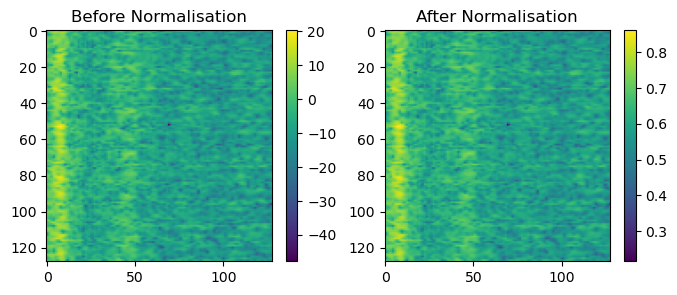

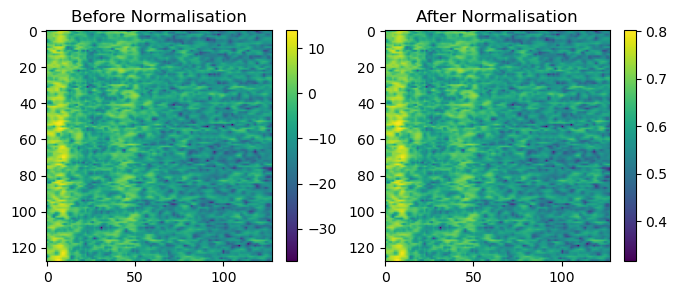

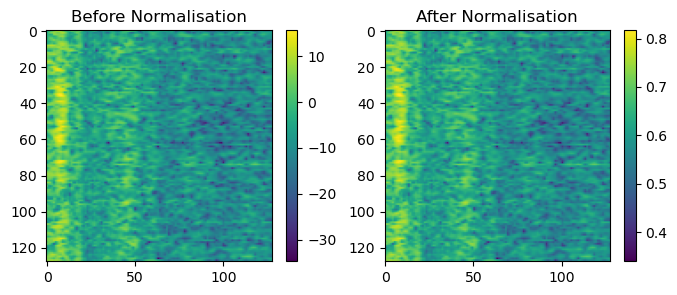

In [94]:
for i in range(3):
    plt.figure(figsize=(8, 3))

    # INPUT
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_square[99 + i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Before Normalisation")
    plt.colorbar()

    # DENOISED OUTPUT
    plt.subplot(1, 2, 2)
    plt.imshow(X_train[99 + i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("After Normalisation")
    plt.colorbar()

In [95]:
# Get testing split
X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=100,
    shuffle=True
)

print("Final input shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Final input shape:
X_train: (10316, 128, 128, 1)
y_train: (10316, 128, 128, 1)
X_test: (2579, 128, 128, 1)
y_test: (2579, 128, 128, 1)


### Initialise model

In [96]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [97]:
# Learning rate decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000, 
    decay_rate=0.9 
)

In [98]:
from models import unet, unet_denoising
reload(unet_denoising)

unet = unet_denoising.get_unet_model(
    input_size=(128, 128, 1), 
    classes=1, # Use 1 for denoising
    dropout=0.5
) 

# unet = unet.get_unet_model(
#     input_size=(128, 128, 1),
#     classes=1,
#     dropout=0.5
# )

unet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss="mse",
    metrics=["mae"]
)

In [99]:
# Train the model

history = unet.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=5,
    validation_split=0.1,
    shuffle=True,
    verbose=2
)

Epoch 1/5
2321/2321 - 1019s - loss: 0.0026 - mae: 0.0378 - val_loss: 0.0011 - val_mae: 0.0257 - 1019s/epoch - 439ms/step
Epoch 2/5
2321/2321 - 1010s - loss: 0.0019 - mae: 0.0343 - val_loss: 0.0011 - val_mae: 0.0246 - 1010s/epoch - 435ms/step
Epoch 3/5
2321/2321 - 1012s - loss: 0.0018 - mae: 0.0332 - val_loss: 8.0592e-04 - val_mae: 0.0213 - 1012s/epoch - 436ms/step
Epoch 4/5
2321/2321 - 1045s - loss: 0.0016 - mae: 0.0314 - val_loss: 9.5832e-04 - val_mae: 0.0244 - 1045s/epoch - 450ms/step
Epoch 5/5
2321/2321 - 1014s - loss: 0.0015 - mae: 0.0306 - val_loss: 9.8298e-04 - val_mae: 0.0247 - 1014s/epoch - 437ms/step


In [100]:
evals = unet.evaluate(
    x=X_test,
    y=y_test,
    batch_size=BATCH_SIZE,
    verbose=2
)

645/645 - 81s - loss: 9.8181e-04 - mae: 0.0248 - 81s/epoch - 126ms/step


In [101]:
unet.save('models/unet_denoiser.keras')

### Evaluation, metrics, and visualising denoised output

In [102]:
num_samples = 5  
sample_indices = np.random.choice(range(X_test.shape[0]), num_samples, replace=False)
sample_inputs = X_test[sample_indices]
sample_targets = y_test[sample_indices]

# Predict the denoised outputs
denoised_outputs = unet.predict(sample_inputs)

1/1 [==============================] - 1s 1s/step


In [103]:
# Get evaluation metrics
mse_score = tf.keras.losses.MeanSquaredError()(sample_inputs, denoised_outputs).numpy()
psnr_score = psnr(sample_inputs, denoised_outputs).numpy()

print(f"MSE: {mse_score}")
print(f"PSNR: {psnr_score}")

MSE: 0.0009933200199157
PSNR: [30.02645  29.886553 30.15267  30.587826 29.557186]


In [104]:
# Check if all outputs are normalised

for output in denoised_outputs:
    print(f"Min: {np.min(output)}; Max: {np.max(output)}")

Min: 0.48046931624412537; Max: 0.7121773958206177
Min: 0.49345943331718445; Max: 0.6792268753051758
Min: 0.48518332839012146; Max: 0.667495846748352
Min: 0.4777384102344513; Max: 0.6514269113540649
Min: 0.5145660638809204; Max: 0.6815125942230225


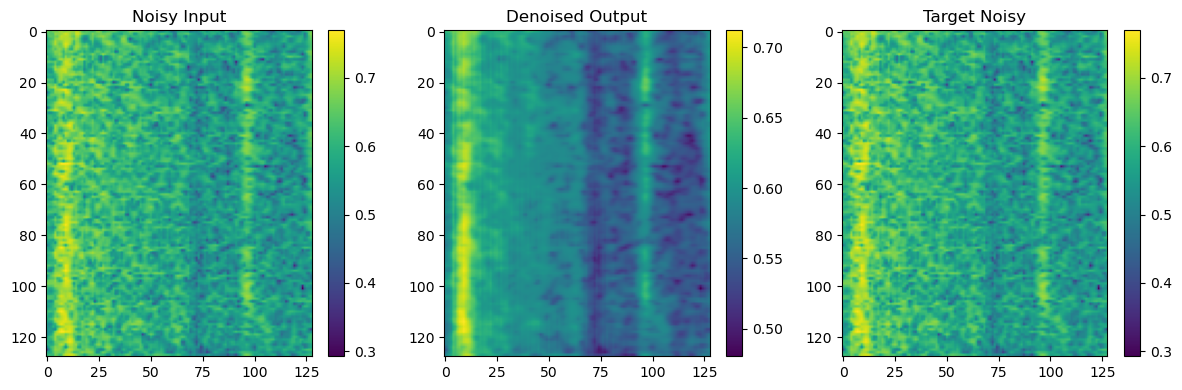

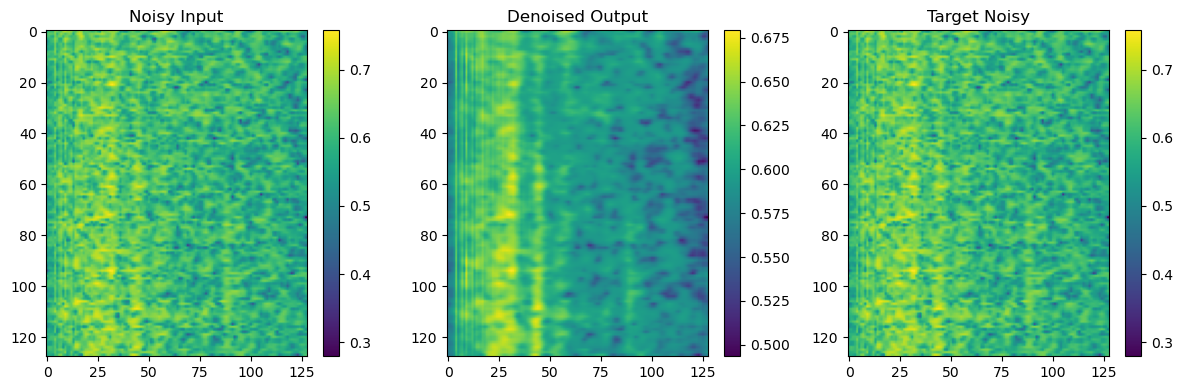

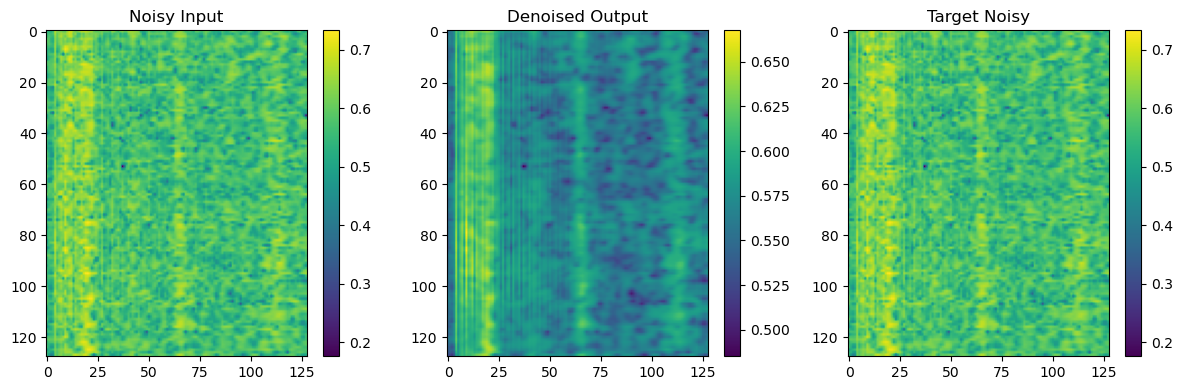

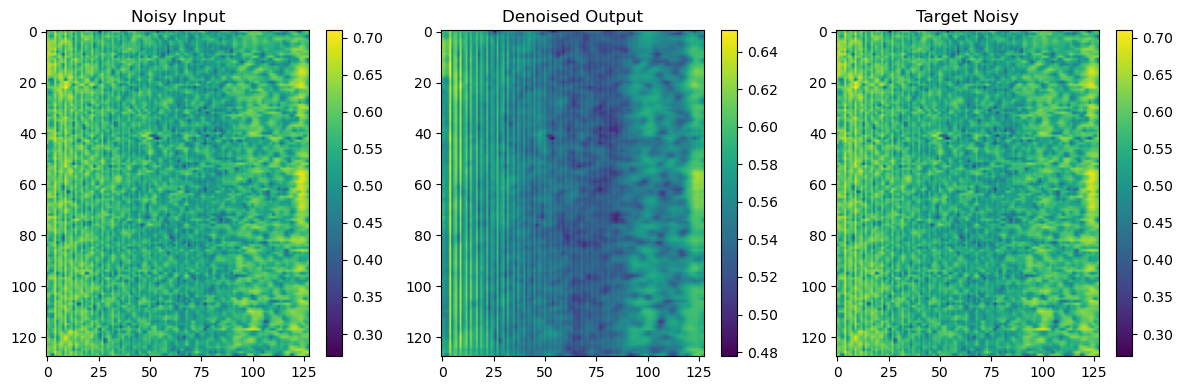

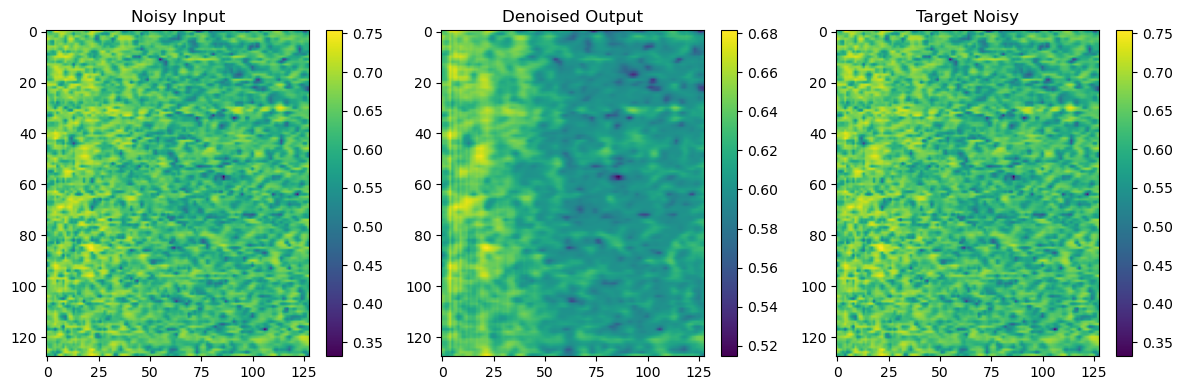

In [105]:
# Plot the input, output, and target spectrograms for each sample
for i in range(num_samples):
    plt.figure(figsize=(12, 4))
    
    # INPUT
    plt.subplot(1, 3, 1)
    plt.imshow(sample_inputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Noisy Input")
    plt.colorbar()

    # DENOISED OUTPUT
    plt.subplot(1, 3, 2)
    plt.imshow(denoised_outputs[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Denoised Output")
    plt.colorbar()

    # TARGET
    plt.subplot(1, 3, 3)
    plt.imshow(sample_targets[i].squeeze(), cmap="viridis", aspect="auto")
    plt.title("Target Noisy")
    plt.colorbar()
    
    plt.tight_layout()
    plt.show()